In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from functions import *
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from numpy import newaxis

In [2]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        w = bbox[1][0] - bbox[0][0]
        h = bbox[1][1] - bbox[0][1]
        a = w*h
        #print(a)
        if a > 3000:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img

8792
8968


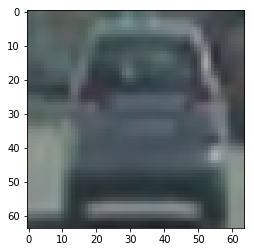

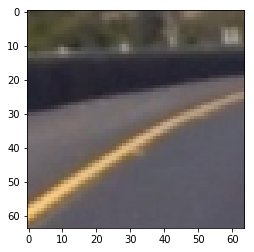

In [3]:
# Divide up into cars and notcars
car_images = glob.glob('vehicles/*/*.png')
not_car_images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for img in car_images:
    cars.append(img)
for img in not_car_images:
    notcars.append(img)

print(len(cars))
print(len(notcars))
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 8500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

plt.imshow(mpimg.imread(cars[5]))
plt.show()
plt.imshow(mpimg.imread(notcars[5]))
plt.show()

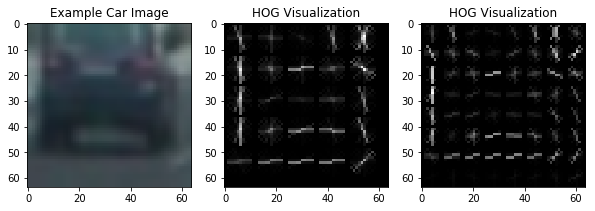

In [4]:
image = mpimg.imread(cars[15])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image1 = get_hog_features(gray, orient= 11, 
                        pix_per_cell= 12, cell_per_block= 2, 
                        vis=True, feature_vec=False)
features, hog_image2 = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [5]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler()
# Apply the scaler to X
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5340
3116.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9821


In [7]:
# Test stacking
a = np.empty((0,2,2), int)
b = np.array([[[1,2],[3,4]]])
c = np.vstack((a,b))
c = np.vstack((c,b))
print(a.shape)
print(b.shape)
print(c.shape)
print(c)

(0, 2, 2)
(1, 2, 2)
(2, 2, 2)
[[[1 2]
  [3 4]]

 [[1 2]
  [3 4]]]


In [8]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = np.copy(img_tosearch)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = np.empty((0,2,2), int)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features,hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = np.array([[[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]]])
                #print(boxes.shape)
                #print(box.shape)
                boxes = np.vstack((boxes,box))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    #print(boxes)    
    return boxes,draw_img

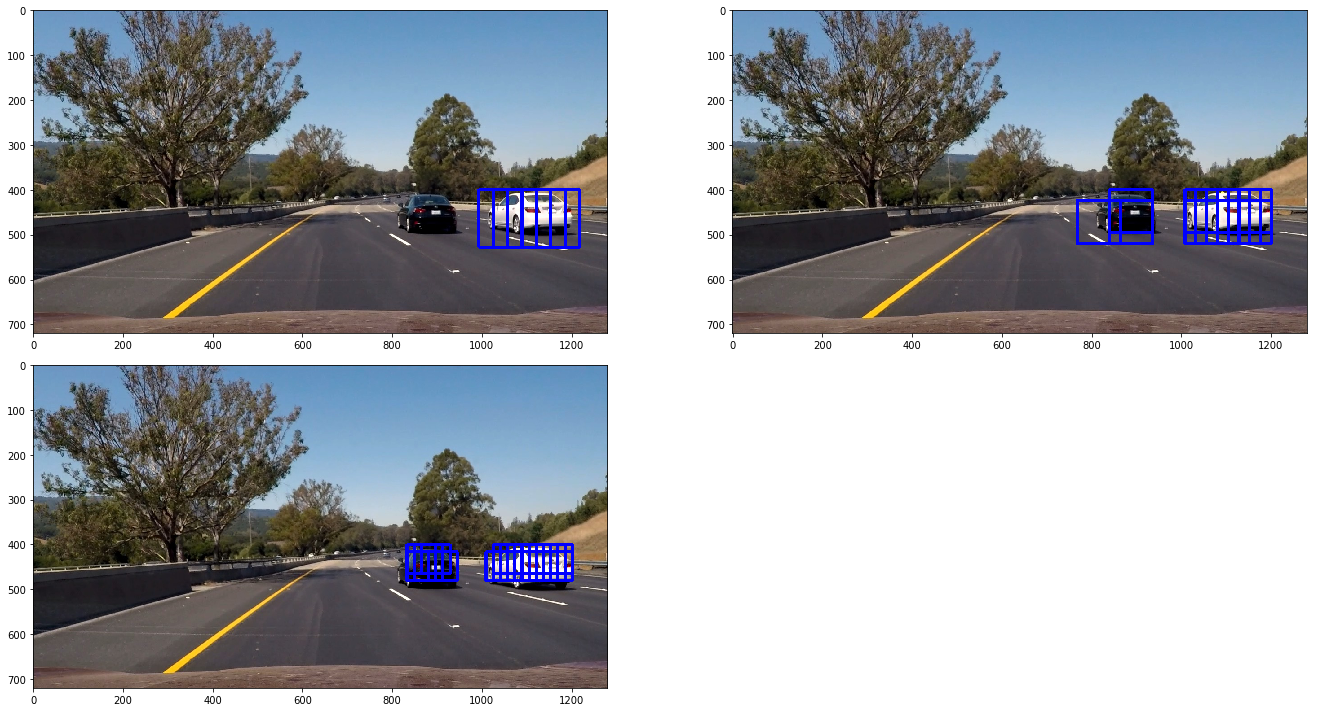

In [15]:
image = mpimg.imread('test_images/test6.jpg')
scale2 = 2.0
ystart2 = 400
ystop2 = 600
box2,img2 = find_cars(image, ystart2, ystop2, scale2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
scale3 = 1.5
ystart3 = 400
ystop3 = 540
box3,img3 = find_cars(image, ystart3, ystop3, scale3, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
scale4 = 1.0
ystart4 = 400
ystop4 = 480
box4,img4 = find_cars(image, ystart4, ystop4, scale4, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
boxes = np.concatenate((box2,box3,box4))

fig = plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(img2)
plt.subplot(222)
plt.imshow(img3)
plt.subplot(223)
plt.imshow(img4)
# plt.subplot(224)
# plt.imshow(img4)
fig.tight_layout()
plt.show()

In [11]:
print(boxes.shape)
print(box2)

(40, 2, 2)
[[[ 992  400]
  [1120  528]]

 [[1024  400]
  [1152  528]]

 [[1056  400]
  [1184  528]]

 [[1088  400]
  [1216  528]]]


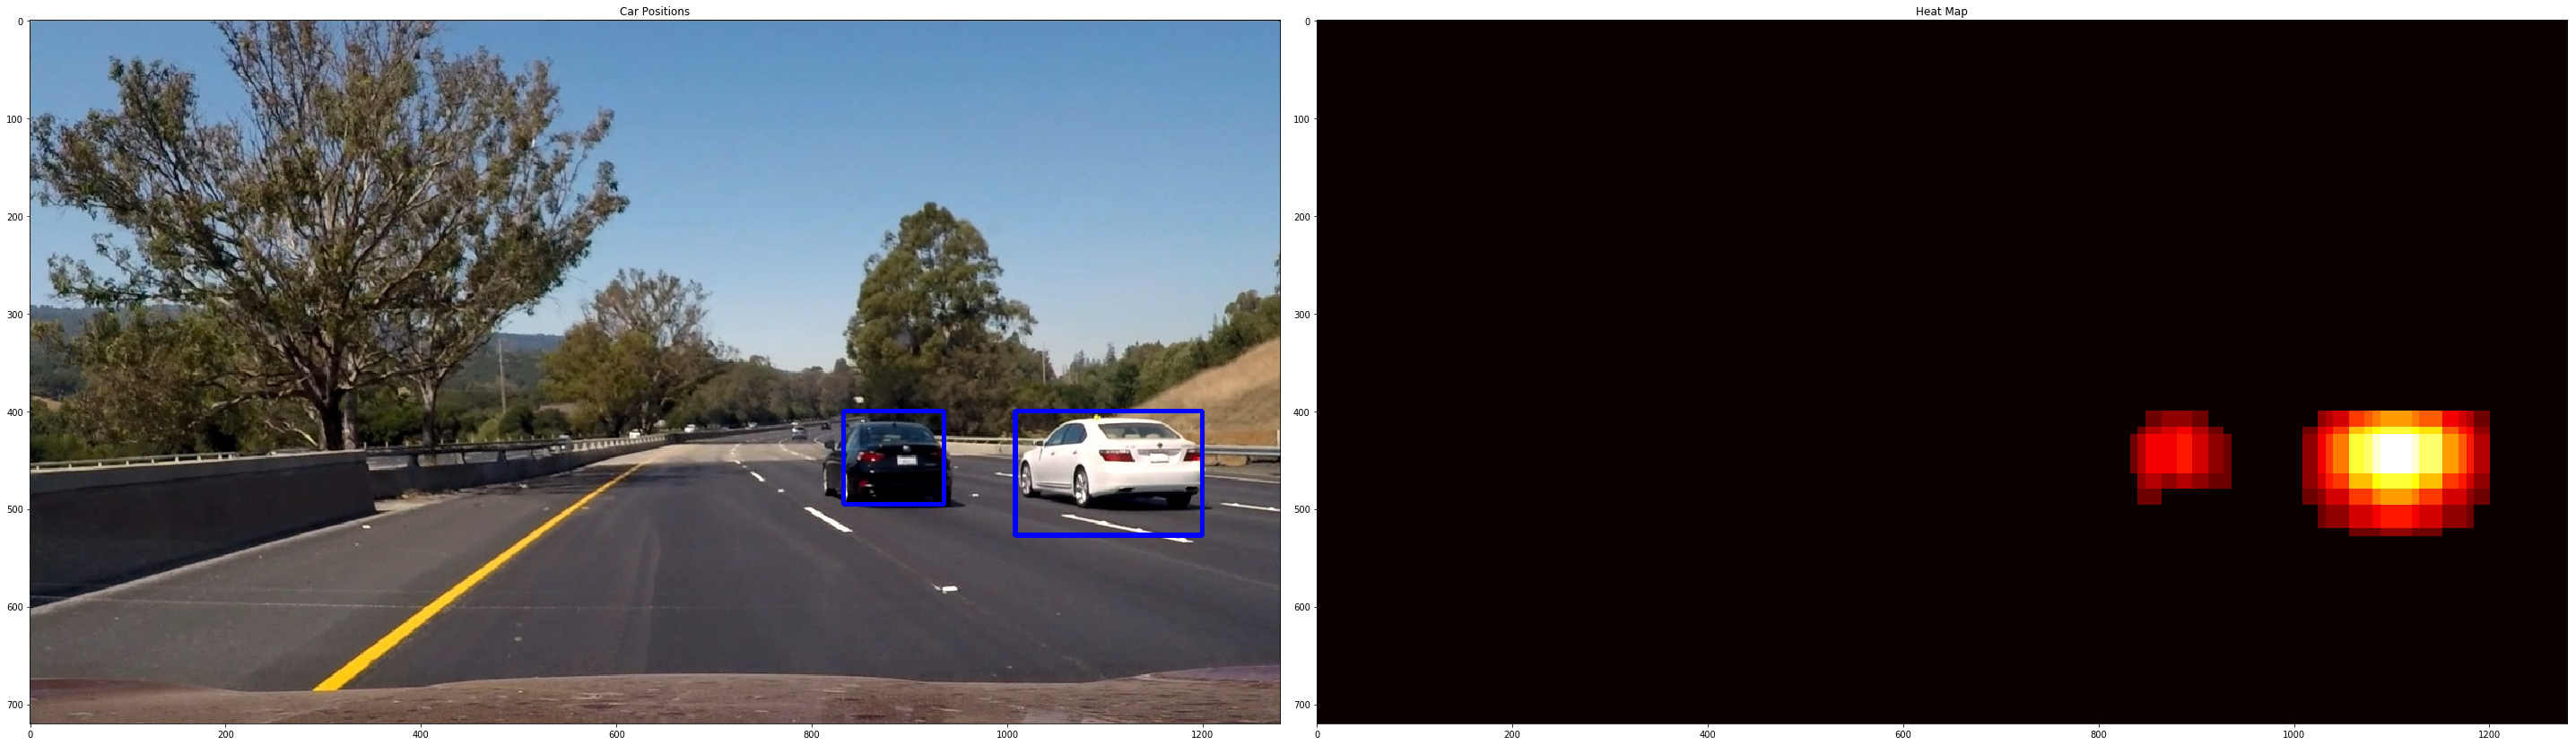

In [16]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure(figsize=(40,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [202]:
cap = cv2.VideoCapture('project_video.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

count = 0
boxes = []
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fourcc = -1
out = cv2.VideoWriter('out_project1.avi',fourcc, 20, (frame_width,frame_height)) 
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Display the resulting frame
#         scale1 = 2.5
#         ystart1 = 350
#         ystop1 = 656
#         box1,img1 = find_cars(frame, ystart1, ystop1, scale1, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        scale2 = 2.0
        ystart2 = 400
        ystop2 = 600
        box2,img2 = find_cars(frame, ystart2, ystop2, scale2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        scale3 = 1.5
        ystart3 = 400
        ystop3 = 540
        box3,img3 = find_cars(frame, ystart3, ystop3, scale3, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        scale4 = 1.0
        ystart4 = 400
        ystop4 = 480
        box4,img4 = find_cars(frame, ystart4, ystop4, scale4, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box = np.concatenate((box2,box3,box4))
        boxes.append(box)
        if(count > 10):
            heat = np.zeros_like(frame[:,:,0]).astype(np.float)
            for box in boxes[count-10:count]:
                heat = add_heat(heat,box)
            heat = apply_threshold(heat,20)  
            heatmap = np.clip(heat, 0, 255)
            labels = label(heatmap)
            result = draw_labeled_bboxes(np.copy(frame), labels)
            out.write(result)
            cv2.imshow('frame',result)
            # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    # Break the loop
    else: 
        break
    print(count)
    count = count +1
# When everything done, release the video capture object
cap.release()
out.release()
 
# Closes all the frames
cv2.destroyAllWindows()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
def process_image(img):
    boxes,img = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,1)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)
    return result

In [ ]:
x = process_image(image)
plt.imshow(x)
plt.show()

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image).subclip(10,15)
%time white_clip.write_videofile(white_output,audio=False)